In [5]:
from understatapi import UnderstatClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

understat = UnderstatClient()

In [4]:
league_data = understat.league(league="EPL").get_match_data(season="2024")

league_data[8]

{'id': '26610',
 'isResult': True,
 'h': {'id': '80', 'title': 'Chelsea', 'short_title': 'CHE'},
 'a': {'id': '88', 'title': 'Manchester City', 'short_title': 'MCI'},
 'goals': {'h': '0', 'a': '2'},
 'xG': {'h': '1.06123', 'a': '1.18038'},
 'datetime': '2024-08-18 15:30:00',
 'forecast': {'w': '0.3036', 'd': '0.3245', 'l': '0.3719'}}

In [8]:
def get_league_data(league: str, seasons: list):
    understat = UnderstatClient()
    all_matches = []
    
    for season in seasons:
        league_data = understat.league(league=league).get_match_data(season=season)
        for match in league_data:
            # Zdarza się, że w "forecast" może nie być danych, więc obsługujemy to przez get() lub warunek
            forecast = match.get("forecast", {})
            
            match_data = {
                "league": league,
                "season": season,
                "match_id": match["id"],
                "date": match["datetime"],
                "home_team": match["h"]["title"],
                "away_team": match["a"]["title"],
                "home_goals": match["goals"]["h"],
                "away_goals": match["goals"]["a"],
                "home_xG": match["xG"]["h"],
                "away_xG": match["xG"]["a"],
                "win_prob": forecast.get("w"),   # prawdopodobieństwo zwycięstwa gospodarza według Understat
                "draw_prob": forecast.get("d"), # prawdopodobieństwo remisu
                "away_win_prob": forecast.get("l") # prawdopodobieństwo wygranej gości
            }
            all_matches.append(match_data)

    df = pd.DataFrame(all_matches)
    return df

seasons = ["2023"]
df_epl = get_league_data("EPL", seasons)

# df_laliga = get_league_data("La_liga", seasons)
# df_bundesliga = get_league_data("Bundesliga", seasons)

# Łączymy dane z wielu lig w jeden DataFrame
# df_all = pd.concat([df_epl, df_laliga, df_bundesliga], ignore_index=True)

print(df_epl.head())

df_epl.to_csv("data_epl_2023_2024.csv", index=False)
print("Data saved.")

  league season match_id                 date    home_team          away_team  \
0    EPL   2023    22275  2023-08-11 19:00:00      Burnley    Manchester City   
1    EPL   2023    22276  2023-08-12 11:30:00      Arsenal  Nottingham Forest   
2    EPL   2023    22277  2023-08-12 14:00:00  Bournemouth           West Ham   
3    EPL   2023    22278  2023-08-12 14:00:00     Brighton              Luton   
4    EPL   2023    22279  2023-08-12 14:00:00      Everton             Fulham   

  home_goals away_goals   home_xG   away_xG win_prob draw_prob away_win_prob  
0          0          3  0.311032   2.40074   0.0177    0.0854        0.8969  
1          2          1   0.84262  0.966305   0.2797    0.3363         0.384  
2          1          1   1.51025    1.4834   0.3559    0.3169        0.3272  
3          4          1   4.36748   1.88594    0.879    0.0876        0.0334  
4          0          1   2.59001   1.58144   0.6371    0.1989         0.164  
Dane zapisane.


In [12]:
df = pd.read_csv("data_epl_2023_2024.csv")
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   league         380 non-null    object 
 1   season         380 non-null    int64  
 2   match_id       380 non-null    int64  
 3   date           380 non-null    object 
 4   home_team      380 non-null    object 
 5   away_team      380 non-null    object 
 6   home_goals     380 non-null    int64  
 7   away_goals     380 non-null    int64  
 8   home_xG        380 non-null    float64
 9   away_xG        380 non-null    float64
 10  win_prob       380 non-null    float64
 11  draw_prob      380 non-null    float64
 12  away_win_prob  380 non-null    float64
dtypes: float64(5), int64(4), object(4)
memory usage: 38.7+ KB
None
league           0
season           0
match_id         0
date             0
home_team        0
away_team        0
home_goals       0
away_goals       0
home_xG        

In [19]:
df['date'] = pd.to_datetime(df['date'])

def get_result(row):
    if row['home_goals'] > row['away_goals']:
        return 1
    elif row['home_goals'] < row['away_goals']:
        return -1
    else:
        return 0


df['match_result'] = df.apply(get_result, axis=1)

df.head()


,league,season,match_id,date,home_team,away_team,home_goals,away_goals,home_xG,away_xG,win_prob,draw_prob,away_win_prob,match_result
0,EPL,2023,22275,2023-08-11 19:00:00,Burnley,Manchester City,0,3,0.311032,2.400740,0.0177,0.0854,0.8969,-1
1,EPL,2023,22276,2023-08-12 11:30:00,Arsenal,Nottingham Forest,2,1,0.842620,0.966305,0.2797,0.3363,0.3840,1
2,EPL,2023,22277,2023-08-12 14:00:00,Bournemouth,West Ham,1,1,1.510250,1.483400,0.3559,0.3169,0.3272,0
3,EPL,2023,22278,2023-08-12 14:00:00,Brighton,Luton,4,1,4.367480,1.885940,0.8790,0.0876,0.0334,1
4,EPL,2023,22279,2023-08-12 14:00:00,Everton,Fulham,0,1,2.590010,1.581440,0.6371,0.1989,0.1640,-1


In [15]:
print(df[["home_goals","away_goals","home_xG","away_xG"]].describe())

       home_goals  away_goals     home_xG     away_xG
count  380.000000  380.000000  380.000000  380.000000
mean     1.800000    1.478947    1.922032    1.458510
std      1.365616    1.277811    1.033890    0.899809
min      0.000000    0.000000    0.088624    0.028155
25%      1.000000    1.000000    1.110132    0.802416
50%      2.000000    1.000000    1.762235    1.291850
75%      3.000000    2.000000    2.628137    1.929960
max      6.000000    8.000000    6.671510    5.108200


In [16]:
df.describe()

,season,match_id,date,home_goals,away_goals,home_xG,away_xG,win_prob,draw_prob,away_win_prob,match_result
count,380.0,380.000000,380,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,2023.0,22124.515789,2024-01-06 13:48:40.263157760,1.800000,1.478947,1.922032,1.458510,0.491884,0.199691,0.308425,0.136842
min,2023.0,21925.000000,2023-08-11 19:00:00,0.000000,0.000000,0.088624,0.028155,0.001000,0.001500,0.000200,-1.000000
25%,2023.0,22019.750000,2023-10-29 07:52:30,1.000000,1.000000,1.110132,0.802416,0.245450,0.119025,0.077475,-1.000000
50%,2023.0,22115.500000,2023-12-30 15:00:00,2.000000,1.000000,1.762235,1.291850,0.480400,0.218450,0.238900,0.000000
75%,2023.0,22210.250000,2024-03-30 15:00:00,3.000000,2.000000,2.628137,1.929960,0.765500,0.273625,0.473700,1.000000
max,2023.0,25861.000000,2024-05-19 15:00:00,6.000000,8.000000,6.671510,5.108200,0.998100,0.488000,0.988400,1.000000
std,0.0,221.337008,NaN,1.365616,1.277811,1.033890,0.899809,0.295519,0.098588,0.271617,0.876073


In [17]:
corr_home = df["home_xG"].corr(df["home_goals"])
corr_away = df["away_xG"].corr(df["away_goals"])
print("Korelacja home_xG z home_goals:", corr_home)
print("Korelacja away_xG z away_goals:", corr_away)

Korelacja home_xG z home_goals: 0.5931873663538461
Korelacja away_xG z away_goals: 0.6510022495076635


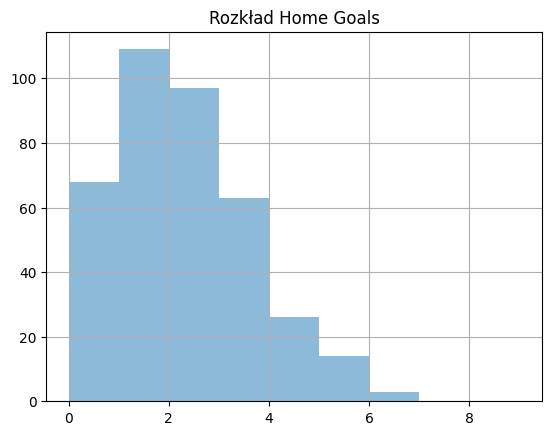

In [18]:
df["home_goals"].hist(bins=range(0,10), alpha=0.5)
plt.title("Rozkład Home Goals")
plt.show()

In [22]:
selected_teams = ["Manchester City", "Arsenal", "Liverpool", "Chelsea", "Manchester United"]

# Filtrowanie meczów, gdzie drużyny grały jako gospodarze lub goście
home_stats = df[df["home_team"].isin(selected_teams)].groupby("home_team").agg(
    total_goals=pd.NamedAgg(column="home_goals", aggfunc="sum"),
    total_xG=pd.NamedAgg(column="home_xG", aggfunc="sum")
).reset_index()

away_stats = df[df["away_team"].isin(selected_teams)].groupby("away_team").agg(
    total_goals=pd.NamedAgg(column="away_goals", aggfunc="sum"),
    total_xG=pd.NamedAgg(column="away_xG", aggfunc="sum")
).reset_index()

# Połączenie wyników gospodarzy i gości
team_stats = pd.merge(home_stats, away_stats, left_on="home_team", right_on="away_team", suffixes=("_home", "_away"))
team_stats["team"] = team_stats["home_team"]
team_stats["total_goals"] = team_stats["total_goals_home"] + team_stats["total_goals_away"]
team_stats["total_xG"] = team_stats["total_xG_home"] + team_stats["total_xG_away"]

# Usuwamy zbędne kolumny
team_stats = team_stats[["team", "total_goals", "total_xG"]]

# Obliczamy różnicę goli do xG
team_stats["goals_xG_diff"] = team_stats["total_goals"] - team_stats["total_xG"]

# Podgląd danych
team_stats

,team,total_goals,total_xG,goals_xG_diff
0,Arsenal,91,84.392479,6.607521
1,Chelsea,77,80.881514,-3.881514
2,Liverpool,86,94.785242,-8.785242
3,Manchester City,96,89.548753,6.451247
4,Manchester United,57,60.329903,-3.329903


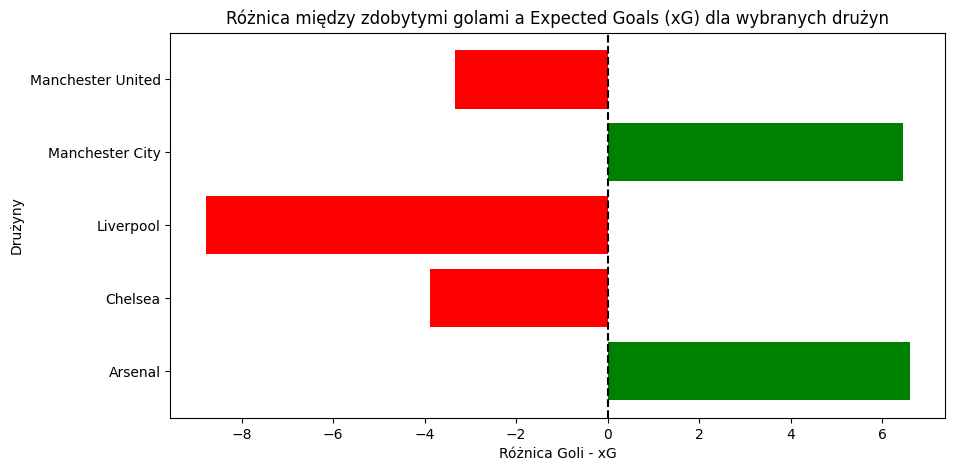

In [21]:
plt.figure(figsize=(10,5))

# Wykres słupkowy różnicy goli do xG dla wybranych drużyn
plt.barh(team_stats["team"], team_stats["goals_xG_diff"], color=["green" if x > 0 else "red" for x in team_stats["goals_xG_diff"]])

plt.xlabel("Różnica Goli - xG")
plt.ylabel("Drużyny")
plt.title("Różnica między zdobytymi golami a Expected Goals (xG) dla wybranych drużyn")
plt.axvline(0, color="black", linestyle="dashed")  # Linia odniesienia dla różnicy 0

plt.show()


In [23]:
def poisson_prob(k, lam):
    # P(X=k) = e^-lam * lam^k / k!
    return (math.exp(-lam) * (lam**k)) / math.factorial(k)


def predict_match_poisson(home_xg, away_xg, max_goals=5):
    p_home_win = 0
    p_draw = 0
    p_away_win = 0

    for h_goals in range(max_goals+1):
        for a_goals in range(max_goals+1):
            ph = poisson_prob(h_goals, home_xg)
            pa = poisson_prob(a_goals, away_xg)
            p = ph * pa

            if h_goals > a_goals:
                p_home_win += p
            elif h_goals == a_goals:
                p_draw += p
            else:
                p_away_win += p

    return p_home_win, p_draw, p_away_win


# Example
home_xg_example = 1.5
away_xg_example = 1.0
p_home_win, p_draw, p_away_win = predict_match_poisson(home_xg_example, away_xg_example)
print(p_home_win, p_draw, p_away_win, (p_home_win + p_draw + p_away_win))


0.48349186445316944 0.2598455141008915 0.25161510352923355 0.9949524820832945


In [25]:
correct = 0
total = 0

for i, row in df.iterrows():
    hxg = row["home_xG"]
    axg = row["away_xG"]
    p_home, p_draw, p_away = predict_match_poisson(hxg, axg)

    # przewidywany wynik = kto ma najwyższe p
    if p_home > p_draw and p_home > p_away:
        pred = 1
    elif p_draw > p_home and p_draw > p_away:
        pred = 0
    else:
        pred = -1

    actual = row["match_result"]
    if pred == actual:
        correct += 1
    total += 1

accuracy = correct / total * 100
print(f"Accuracy modelu Poissona: {accuracy:.2f}%")


Accuracy modelu Poissona: 62.63%
